In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, and_

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [4]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [5]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [6]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [7]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
session = Session(engine)

Precipitation Analysis

In [10]:
#last 12 mos of precip data
sel = [Measurement.date,
       Measurement.prcp]
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
last_year = session.query(*sel).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()
last_year

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

In [11]:
precip_2017 = pd.DataFrame(last_year, columns=['date', 'prcp'])
precip_2017.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


In [12]:
precip_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 2 columns):
date    2021 non-null object
prcp    2021 non-null float64
dtypes: float64(1), object(1)
memory usage: 31.7+ KB


In [13]:
precip_2017['date'] = pd.to_datetime(precip_2017['date'],format='%Y-%m-%d')

In [14]:
precip_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 2 columns):
date    2021 non-null datetime64[ns]
prcp    2021 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.7 KB


In [15]:
precip_2017.set_index('date', inplace=True)

In [16]:
precip_2017.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [17]:
precip_2017.replace(0.00, np.nan, inplace=True)


In [18]:
precip_2017.head()

,prcp
date,
2016-08-23,NaN
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [19]:
precip_2017 = precip_2017.dropna()

In [20]:
precip_2017.head()

,prcp
date,
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70


In [21]:
precip_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1147 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
prcp    1147 non-null float64
dtypes: float64(1)
memory usage: 17.9 KB


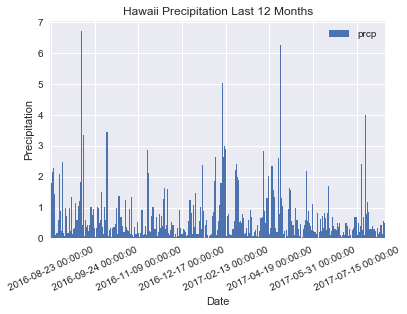

In [22]:
sns.set()

#ax = sns.barplot(y='date', data=precip_2017)
ax = precip_2017.plot(kind='bar', y='prcp', width=4)

plt.title("Hawaii Precipitation Last 12 Months")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.grid(True)

n = 150

ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

#plt.savefig("Hawaii_Precip_12mos.png", dpi=350)
plt.show()

Station Analysis

In [23]:
#count of stations
station_count = session.query(Station).group_by(Station.station).count()
print(station_count)

9


In [24]:
#most active stations/observation counts
sel = [Station.name,
       Measurement.station,  
       func.count(Measurement.tobs)]
station_join = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.tobs))).all()
   
  
print(station_join)

[('WAIHEE 837.5, HI US', 'USC00519281', 2772), ('KANEOHE 838.1, HI US', 'USC00513117', 2696), ('WAIKIKI 717.2, HI US', 'USC00519397', 2685), ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572), ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 1937), ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932), ('PEARL CITY, HI US', 'USC00517948', 683), ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]


In [25]:
stations_df = pd.DataFrame(station_join, columns=['station name','station id','tobs count'])
stations_df.head()

,station name,station id,tobs count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"KANEOHE 838.1, HI US",USC00513117,2696
2,"WAIKIKI 717.2, HI US",USC00519397,2685
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2572
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2484


In [26]:
#most active stations/observation counts last 12 mos
sel = [Station.name,
       Measurement.station,  
       func.count(Measurement.tobs)]
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
station_join2 = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= year_ago).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.tobs))).all()
   
  
print(station_join2)

[('WAIKIKI 717.2, HI US', 'USC00519397', 359), ('WAIHEE 837.5, HI US', 'USC00519281', 352), ('KANEOHE 838.1, HI US', 'USC00513117', 343), ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 328), ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 314), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 265), ('PEARL CITY, HI US', 'USC00517948', 60)]


In [27]:
stations_df2 = pd.DataFrame(station_join2, columns=['station name','station id','tobs count'])
stations_df2.head()

,station name,station id,tobs count
0,"WAIKIKI 717.2, HI US",USC00519397,359
1,"WAIHEE 837.5, HI US",USC00519281,352
2,"KANEOHE 838.1, HI US",USC00513117,343
3,"MANOA LYON ARBO 785.2, HI US",USC00516128,328
4,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,314


In [28]:
#last 12 months of tobs data/filter by highest count
sel = [Measurement.date,
       Station.station,
       Station.name,
       Measurement.tobs]
       #func.count(Measurement.tobs)]
       
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
tobs_join = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= year_ago).\
    filter(Station.station == 'USC00519397').\
    order_by(Measurement.date).all()
    #group_by(Station.station).\
    #order_by(Station.station).all()
    #order_by(desc(func.count(Measurement.tobs))).all()
    
print(tobs_join)

[('2016-08-23', 'USC00519397', 'WAIKIKI 717.2, HI US', 81), ('2016-08-24', 'USC00519397', 'WAIKIKI 717.2, HI US', 79), ('2016-08-25', 'USC00519397', 'WAIKIKI 717.2, HI US', 80), ('2016-08-26', 'USC00519397', 'WAIKIKI 717.2, HI US', 79), ('2016-08-27', 'USC00519397', 'WAIKIKI 717.2, HI US', 77), ('2016-08-28', 'USC00519397', 'WAIKIKI 717.2, HI US', 78), ('2016-08-29', 'USC00519397', 'WAIKIKI 717.2, HI US', 78), ('2016-08-30', 'USC00519397', 'WAIKIKI 717.2, HI US', 79), ('2016-08-31', 'USC00519397', 'WAIKIKI 717.2, HI US', 80), ('2016-09-01', 'USC00519397', 'WAIKIKI 717.2, HI US', 81), ('2016-09-02', 'USC00519397', 'WAIKIKI 717.2, HI US', 80), ('2016-09-03', 'USC00519397', 'WAIKIKI 717.2, HI US', 79), ('2016-09-04', 'USC00519397', 'WAIKIKI 717.2, HI US', 75), ('2016-09-07', 'USC00519397', 'WAIKIKI 717.2, HI US', 76), ('2016-09-08', 'USC00519397', 'WAIKIKI 717.2, HI US', 80), ('2016-09-09', 'USC00519397', 'WAIKIKI 717.2, HI US', 79), ('2016-09-10', 'USC00519397', 'WAIKIKI 717.2, HI US', 7

In [29]:
tobs_df = pd.DataFrame(tobs_join, columns=['date','station id','station name','tobs'])
tobs_df.head()

,date,station id,station name,tobs
0,2016-08-23,USC00519397,"WAIKIKI 717.2, HI US",81
1,2016-08-24,USC00519397,"WAIKIKI 717.2, HI US",79
2,2016-08-25,USC00519397,"WAIKIKI 717.2, HI US",80
3,2016-08-26,USC00519397,"WAIKIKI 717.2, HI US",79
4,2016-08-27,USC00519397,"WAIKIKI 717.2, HI US",77


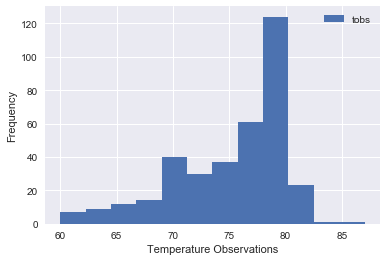

In [30]:
#tobs data histogram
sns.set()
fig, ax = plt.subplots()
sns.distplot(tobs_df['tobs'], bins=12, kde=False, hist_kws=dict(alpha=1))

plt.ylabel("Frequency")
plt.xlabel("Temperature Observations")


ax.legend(['tobs'])
plt.show()


Temperature Analysis

In [31]:
def calc_temps(start_date, end_date):
    start_date = start_date
    end_date = end_date
    
    sel = [Measurement.date,
           Measurement.tobs,
           func.avg(Measurement.tobs),
           func.max(Measurement.tobs),
           func.min(Measurement.tobs)]
    date_choice = session.query(*sel).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
    
    return(date_choice)

calc_temps('2017-04-01','2017-04-12')


[('2017-04-01', 69, 75.5, 80, 69),
 ('2017-04-02', 71, 75.33333333333333, 79, 71),
 ('2017-04-03', 70, 74.33333333333333, 77, 70),
 ('2017-04-04', 67, 74.14285714285714, 78, 67),
 ('2017-04-05', 69, 73.85714285714286, 78, 69),
 ('2017-04-06', 67, 73.42857142857143, 77, 67),
 ('2017-04-07', 74, 75.83333333333333, 78, 74),
 ('2017-04-08', 73, 75.66666666666667, 77, 73),
 ('2017-04-09', 69, 72.25, 78, 69),
 ('2017-04-10', 67, 73.16666666666667, 79, 67),
 ('2017-04-11', 70, 75.66666666666667, 82, 70),
 ('2017-04-12', 69, 74.66666666666667, 80, 69)]

In [32]:
#year ago
def calc_temps(start_date, end_date):
    start_date = start_date
    end_date = end_date
    
    sel = [Measurement.date,
           Measurement.tobs,
           func.avg(Measurement.tobs),
           func.max(Measurement.tobs),
           func.min(Measurement.tobs)]
    year_start = dt.date(2018, 4, 1) - dt.timedelta(days=365)
    year_end = dt.date(2018, 4, 12) - dt.timedelta(days=365)
    
    yr_date_choice = session.query(*sel).\
        filter(Measurement.date >= year_start, Measurement.date <= year_end).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

    return(yr_date_choice)

calc_temps(2018-4-1, 2018-4-12)

[('2017-04-01', 69, 75.5, 80, 69),
 ('2017-04-02', 71, 75.33333333333333, 79, 71),
 ('2017-04-03', 70, 74.33333333333333, 77, 70),
 ('2017-04-04', 67, 74.14285714285714, 78, 67),
 ('2017-04-05', 69, 73.85714285714286, 78, 69),
 ('2017-04-06', 67, 73.42857142857143, 77, 67),
 ('2017-04-07', 74, 75.83333333333333, 78, 74),
 ('2017-04-08', 73, 75.66666666666667, 77, 73),
 ('2017-04-09', 69, 72.25, 78, 69),
 ('2017-04-10', 67, 73.16666666666667, 79, 67),
 ('2017-04-11', 70, 75.66666666666667, 82, 70),
 ('2017-04-12', 69, 74.66666666666667, 80, 69)]

In [33]:
#query for bar chart
sel = [Measurement.date,
           Measurement.tobs,
           func.avg(Measurement.tobs),
           func.max(Measurement.tobs),
           func.min(Measurement.tobs)]
year_start = dt.date(2018, 4, 1) - dt.timedelta(days=365)
year_end = dt.date(2018, 4, 12) - dt.timedelta(days=365)
yr_date_choice = session.query(*sel).\
    filter(Measurement.date >= '2017-04-01', Measurement.date <= '2017-04-12').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
        
print(yr_date_choice)        

[('2017-04-01', 69, 75.5, 80, 69), ('2017-04-02', 71, 75.33333333333333, 79, 71), ('2017-04-03', 70, 74.33333333333333, 77, 70), ('2017-04-04', 67, 74.14285714285714, 78, 67), ('2017-04-05', 69, 73.85714285714286, 78, 69), ('2017-04-06', 67, 73.42857142857143, 77, 67), ('2017-04-07', 74, 75.83333333333333, 78, 74), ('2017-04-08', 73, 75.66666666666667, 77, 73), ('2017-04-09', 69, 72.25, 78, 69), ('2017-04-10', 67, 73.16666666666667, 79, 67), ('2017-04-11', 70, 75.66666666666667, 82, 70), ('2017-04-12', 69, 74.66666666666667, 80, 69)]


In [34]:
yr_date_choice_df = pd.DataFrame(yr_date_choice, columns=['date','temperature','avg. temp','max. temp', 'min. temp'])
yr_date_choice_df.head()

,date,temperature,avg. temp,max. temp,min. temp
0,2017-04-01,69,75.500000,80,69
1,2017-04-02,71,75.333333,79,71
2,2017-04-03,70,74.333333,77,70
3,2017-04-04,67,74.142857,78,67
4,2017-04-05,69,73.857143,78,69


In [86]:
yr_date_choice_df.set_index('date', inplace=True)

In [87]:
yr_date_choice_df.head()

,temperature,avg. temp,max. temp,min. temp
date,,,,
2017-04-01,69,75.500000,80,69
2017-04-02,71,75.333333,79,71
2017-04-03,70,74.333333,77,70
2017-04-04,67,74.142857,78,67
2017-04-05,69,73.857143,78,69


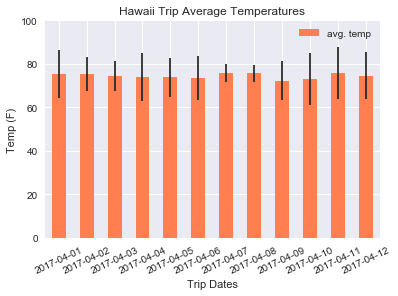

In [91]:
sns.set()
fig, ax = plt.subplots()

error = yr_date_choice_df['max. temp'] - yr_date_choice_df['min. temp']

ax = yr_date_choice_df.plot.bar(y='avg. temp', yerr=error, color="coral", ax=ax)

n = 1

ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n], rotation=25)
ax.xaxis.set_label_text('Trip Dates')

plt.title("Hawaii Trip Average Temperatures")
plt.ylabel("Temp (F)")
plt.grid(True)
plt.ylim([0, 100])


plt.show()